In [2]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib import pylab as plt

In [3]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")

# Chapter 9 - MARKOV CHAIN MONTE CARLO

### 9E1.

Which of the following is a requirement of the simple Metropolis algorithm?

(1) The parameters must be discrete.

(2) The likelihood function must be Gaussian.

(3) The proposal distribution must be symmetric

#### Answer 
 3)The proposal distribution must be symmetric.

### 9E2.

Gibbs sampling is more efficient than the Metropolis algorithm. How does it achieve this extra
efficiency? Are there any limitations to the Gibbs sampling strategy?

#### Answer 
 Adaptive proposals. Gibbs samplers can make dynamically modify the distribution of the next place it will explore in the distribution based on the models current location in parameter space.

### 9E3.

Which sort of parameters can Hamiltonian Monte Carlo not handle? Can you explain why?

#### Answer 
 It relies on doing classical mechanics style simulations of particles moving in a potential energy field. The important point is that the particle should be able to stop at any point, which it can't in a discrete phases space.

### 9E5.

Which value should Rhat approach, when a chain is sampling the posterior distribution correctly?

#### Answer 
 It should approach 1 from above


### 9M1.

Re-estimate the terrain ruggedness model from the chapter, but now using a uniform prior
for the standard deviation, sigma. The uniform prior should be dunif(0,1). Use ulam to estimate
the posterior. Does the different prior have any detectible influence on the posterior distribution of
sigma? Why or why not?

In [4]:
Rugged = pd.read_csv("./data/rugged.csv", delimiter=";")

In [5]:
# get the complete cases
Complete = Rugged.dropna(axis=0, subset=["rgdppc_2000"])
# lets standardise the variables like how he does in the book
Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
Complete["s_log_gdp"] = Complete["log_gdp"] / np.mean(Complete["log_gdp"])
Complete["s_rugged"] = Complete["rugged"] / np.max(Complete["rugged"])

<ipython-input-5-0b4a5213310d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
<ipython-input-5-0b4a5213310d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["s_log_gdp"] = Complete["log_gdp"] / np.mean(Complete["log_gdp"])
<ipython-input-5-0b4a5213310d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [6]:
# just run the standard model m8_3

with pm.Model() as m8_3:
    a = pm.Normal("a", 0, 0.1, shape=2)
    b = pm.Normal("b", 0, 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    mu = a[Complete.cont_africa] + b[Complete.cont_africa] * (
        Complete["s_rugged"] - 0.215
    )
    lgdp_std = pm.Normal("lgdp_std", mu=mu, sd=sigma, observed=Complete["s_log_gdp"])
    m8_3_sample = pm.sample(draws=1000, chains=4)

# run model m8_3 with a uniform prior

with pm.Model() as unif_sig_m8_3:
    a = pm.Normal("a", 0, 0.1, shape=2)
    b = pm.Normal("b", 0, 0.3, shape=2)
    sigma = pm.Uniform("sigma", 0, 1)
    mu = a[Complete.cont_africa] + b[Complete.cont_africa] * (
        Complete["s_rugged"] - 0.215
    )
    lgdp_std = pm.Normal("lgdp_std", mu=mu, sd=sigma, observed=Complete["s_log_gdp"])
    unif_sig_m8_3_sample = pm.sample(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


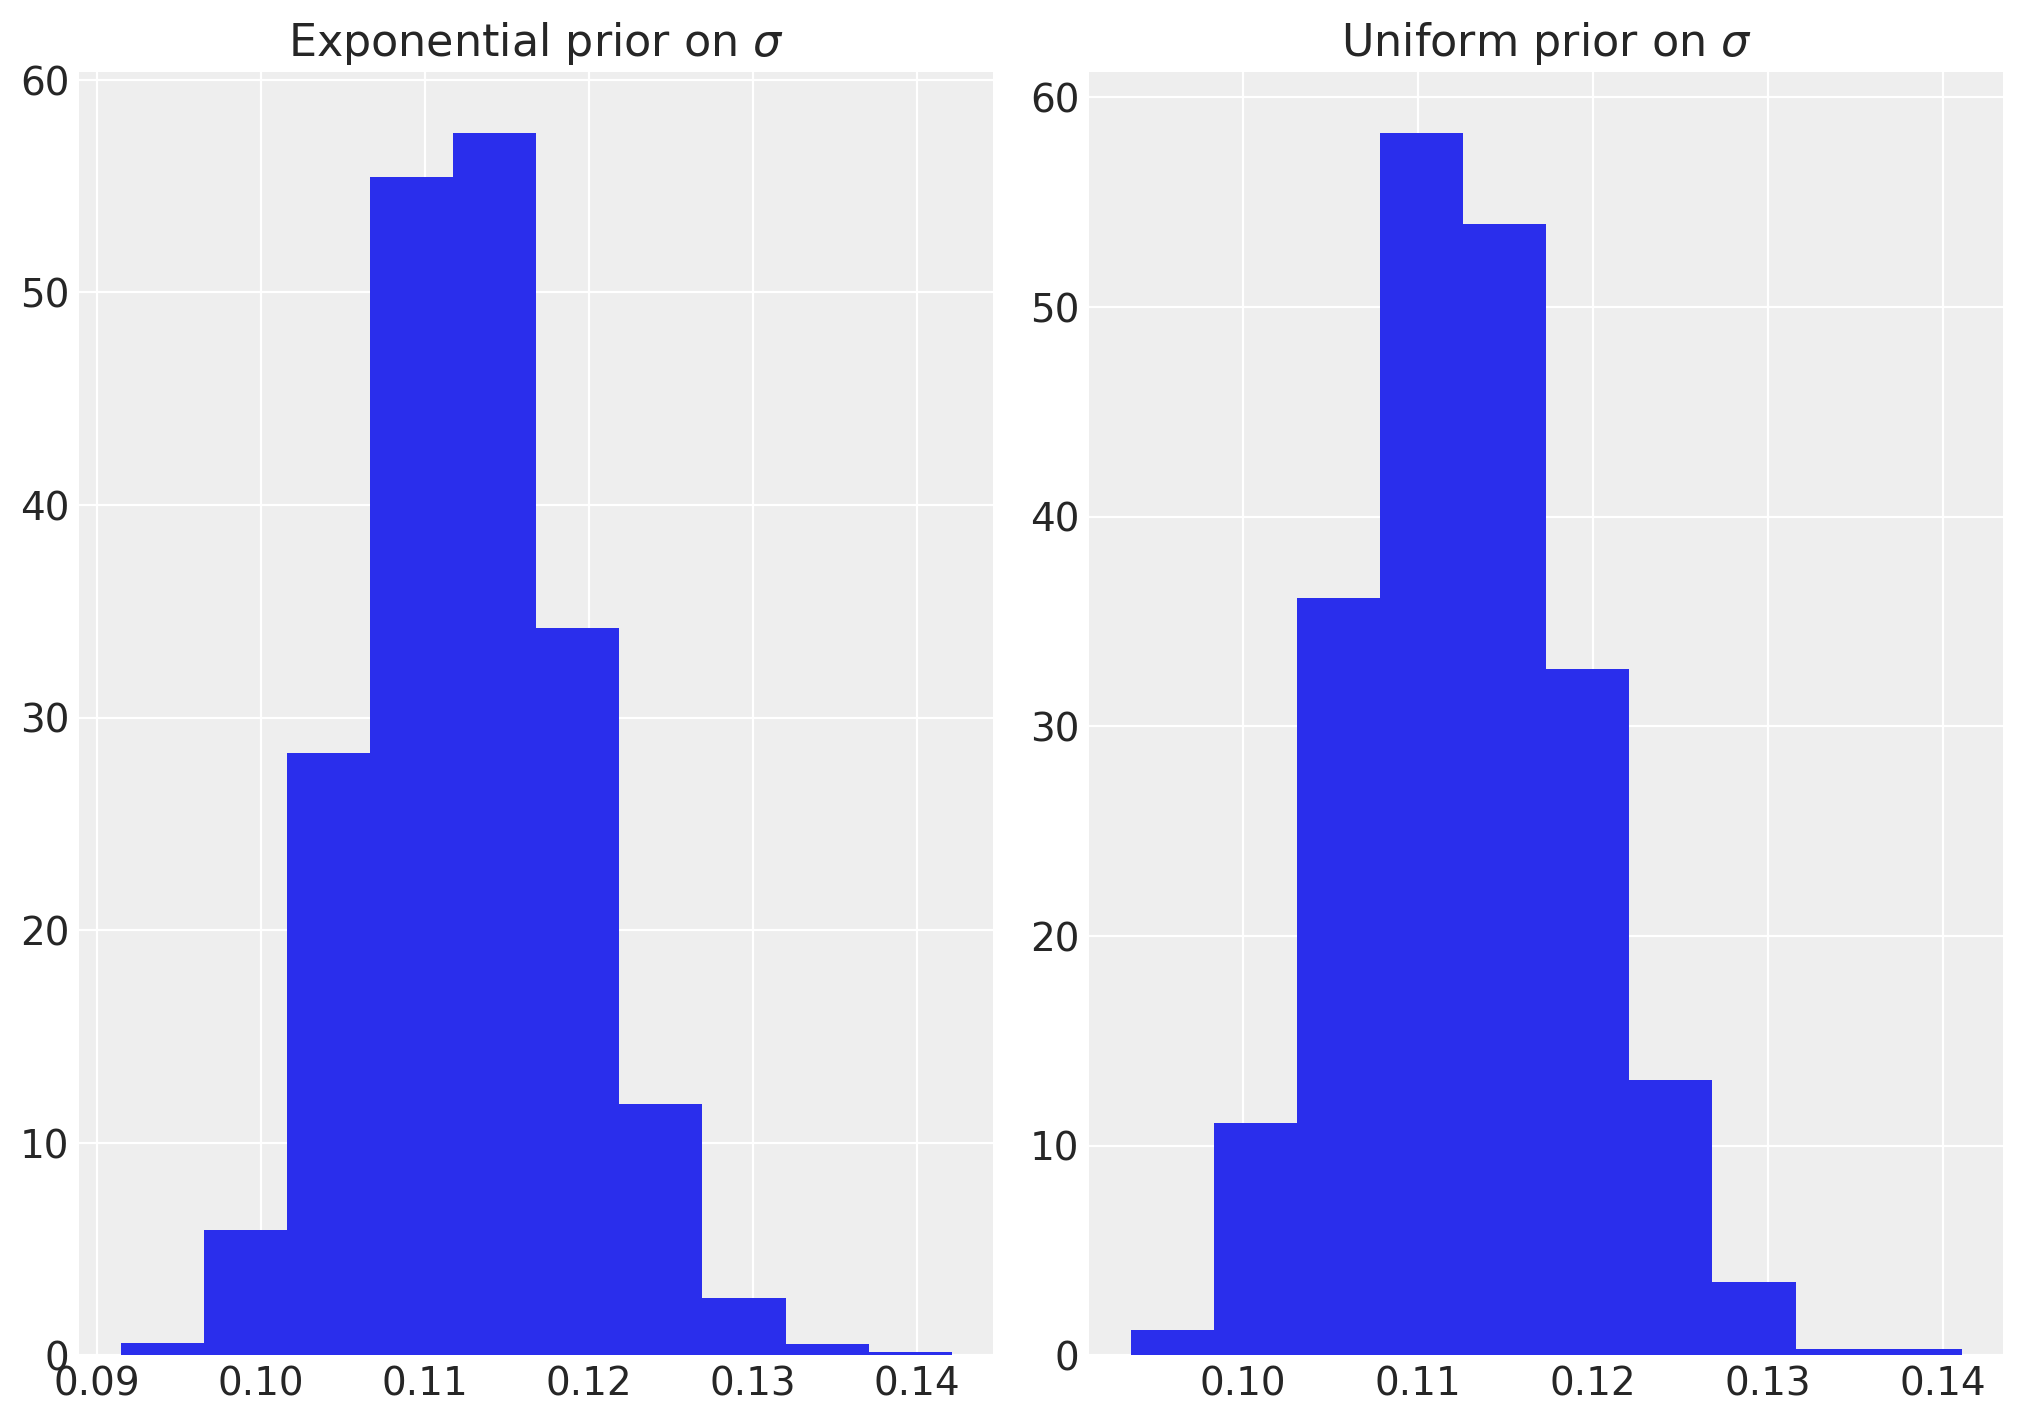

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].hist(m8_3_sample["sigma"], density=True)
axs[0].set_title("Exponential prior on $\sigma$")

axs[1].hist(unif_sig_m8_3_sample["sigma"], density=True)
axs[1].set_title("Uniform prior on $\sigma$")

plt.show()

In [9]:
az.summary(m8_3_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.021,1.059,0.000,0.000,6613.0,6600.0,6578.0,3164.0,1.0
a[1],0.861,0.017,0.831,0.893,0.000,0.000,6006.0,6006.0,6021.0,3082.0,1.0
b[0],-0.137,0.057,-0.245,-0.033,0.001,0.001,7475.0,6208.0,7490.0,2627.0,1.0
b[1],0.111,0.076,-0.037,0.249,0.001,0.001,7103.0,4971.0,7062.0,3249.0,1.0
sigma,0.113,0.006,0.100,0.124,0.000,0.000,5716.0,5645.0,5768.0,3329.0,1.0


In [8]:
az.summary(unif_sig_m8_3_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.011,1.020,1.060,0.000,0.000,6540.0,6540.0,6541.0,3030.0,1.0
a[1],0.861,0.016,0.831,0.892,0.000,0.000,6814.0,6814.0,6806.0,3328.0,1.0
b[0],-0.138,0.058,-0.247,-0.034,0.001,0.001,6437.0,5541.0,6403.0,3524.0,1.0
b[1],0.112,0.079,-0.034,0.262,0.001,0.001,5837.0,3909.0,5825.0,3015.0,1.0
sigma,0.113,0.006,0.101,0.125,0.000,0.000,6535.0,6402.0,6676.0,3062.0,1.0


Switching the $\sigma$ prior from Exp(1) to Unif(0,1) really doesn't do a great deal to the model. We generally expect the model to choose a value less than one and this is what both of these priors anticipate, the exponential only partially (with 63% of it's mass for $\sigma \leq 1$ ), the uniform absolutely (With all of it's mass less than 1).

Moreover, there's a lot of data for the models to learn from, and as both of these priors have similar enough qualitative expectations, the data drowns out any of the differences.

### 9M2.

Modify the terrain ruggedness model again. This time, change the prior for b[cid] to dexp(0.3).
What does this do to the posterior distribution? Can you explain it?

#### Answer 
Presumably this means change the original model, and not to add this change in addition to the uniform change that we did above.

In [15]:
with pm.Model() as b_exp_m8_3:
    a = pm.Normal("a", 0, 0.1, shape=2)
    b = pm.Exponential("b", 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    mu = a[Complete.cont_africa] + b[Complete.cont_africa] * (
        Complete["s_rugged"] - 0.215
    )
    lgdp_std = pm.Normal("lgdp_std", mu=mu, sd=sigma, observed=Complete["s_log_gdp"])
    b_exp_m8_3_sample = pm.sample(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


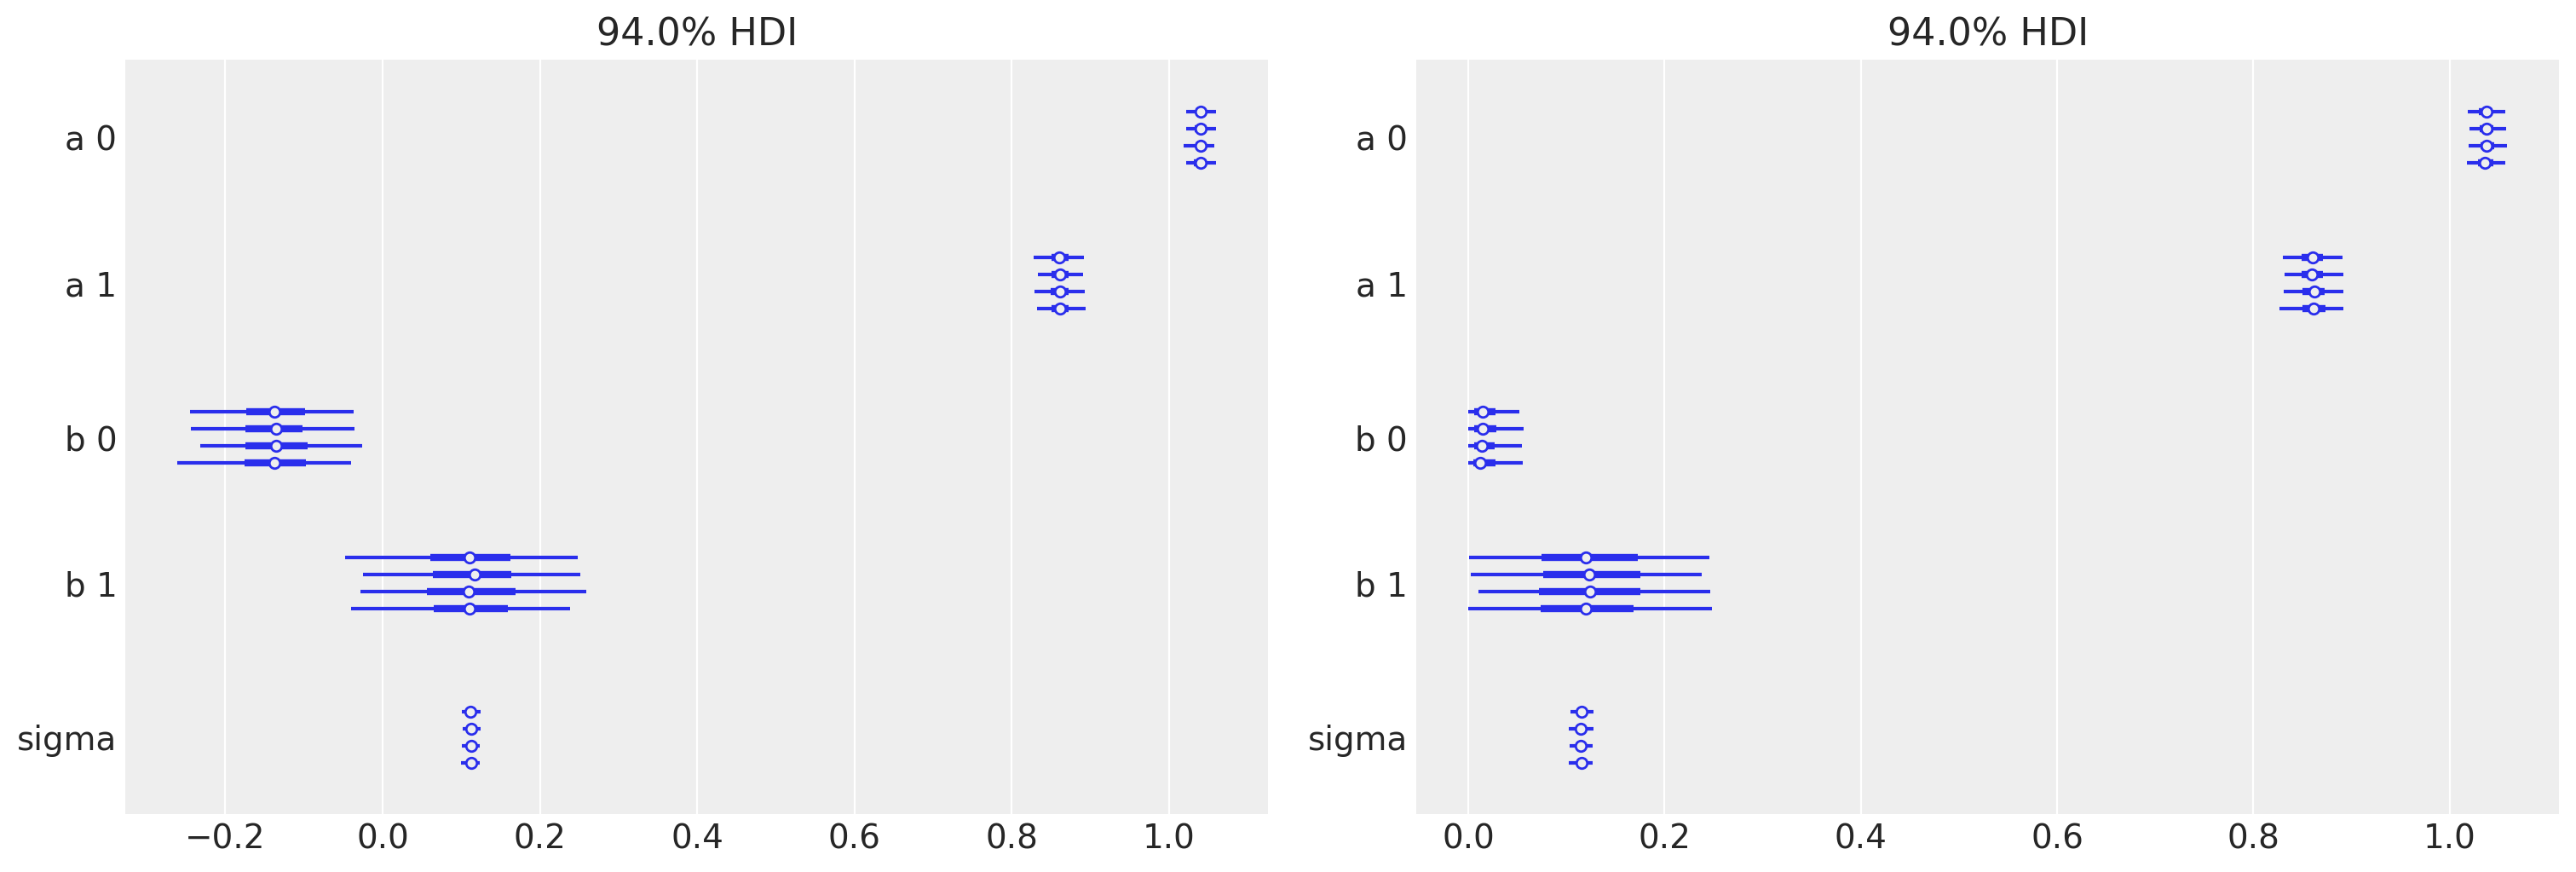

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


az.plot_forest(m8_3_sample, ax=axs[0])

az.plot_forest(b_exp_m8_3_sample, ax=axs[1]);

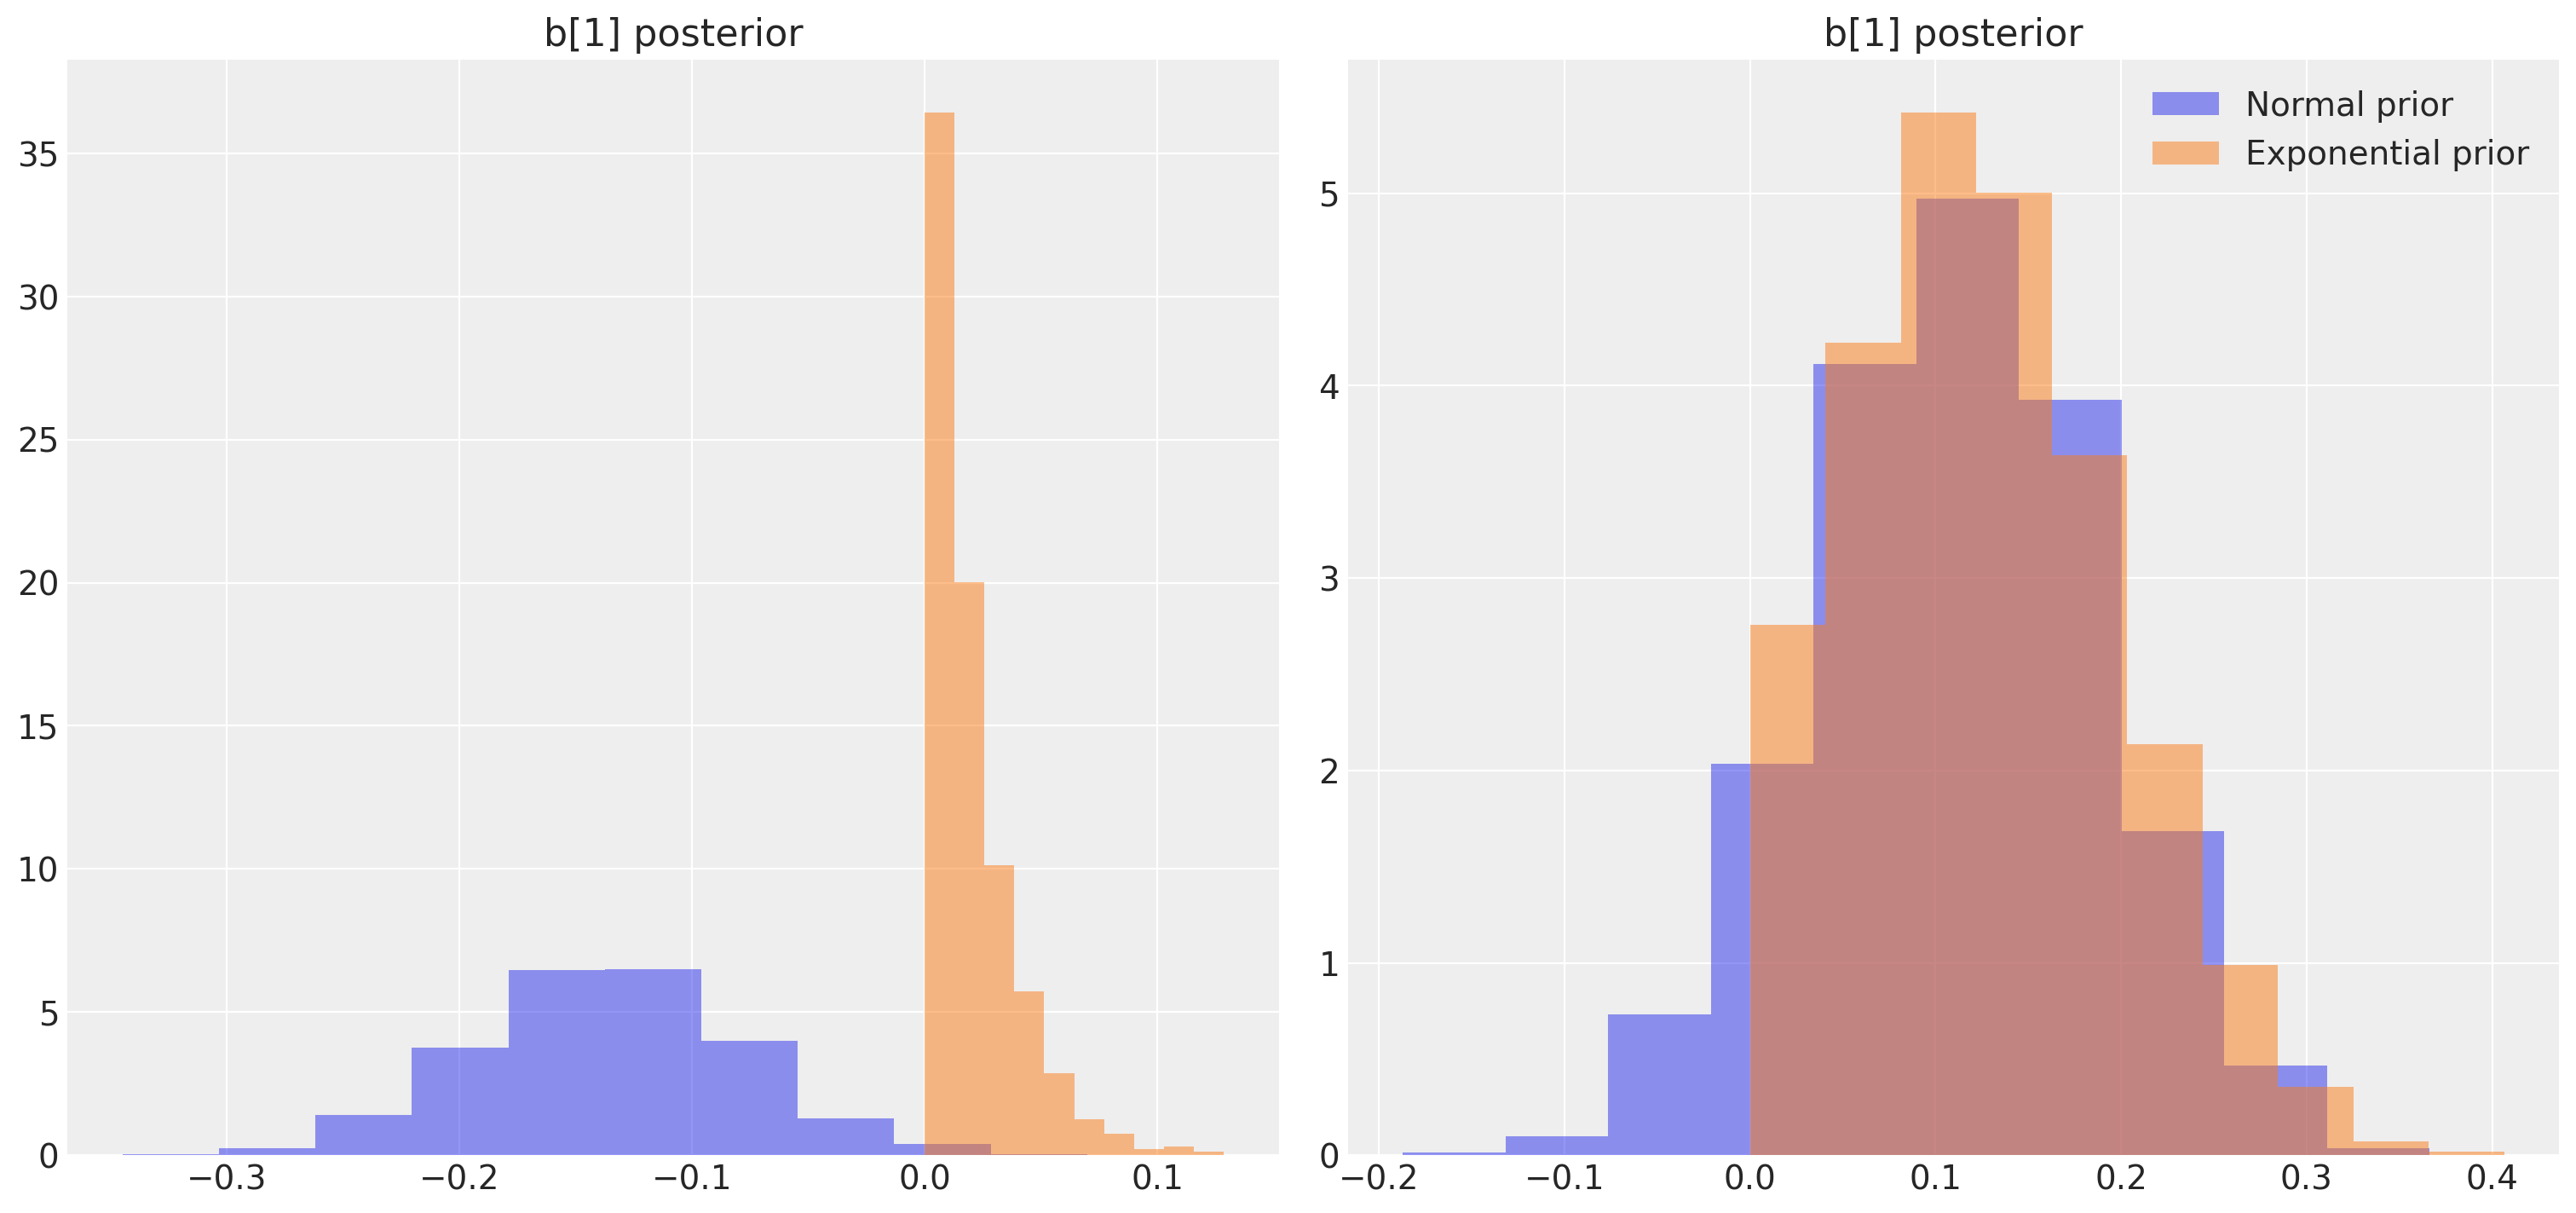

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].hist(m8_3_sample["b"][:, 0], density=True, alpha=0.5, label="Normal prior")
axs[0].hist(
    b_exp_m8_3_sample["b"][:, 0], density=True, alpha=0.5, label="Exponential prior"
)
axs[0].set_title("b[1] posterior")

axs[1].hist(m8_3_sample["b"][:, 1], density=True, alpha=0.5, label="Normal prior")
axs[1].hist(
    b_exp_m8_3_sample["b"][:, 1], density=True, alpha=0.5, label="Exponential prior"
)
axs[1].set_title("b[1] posterior")

plt.legend();

This simply constrains the parameters to be positive, as I stated above. Nothing else too spooky has occurs here that I can observe.

### 9M3.

Re-estimate one of the Stan models from the chapter, but at different numbers of warmup iterations. Be sure to use the same number of sampling iterations in each case. Compare the n_eff
values. How much warmup is enough?

#### Answers:

To translate terms from the book into pymc3:

n_eff = ess_mean

Rhat4 = r_hat

In [20]:
# get samples with different amounts of tuning
with m8_3:
    tune10 = pm.sample(draws=1000, chains=4, tune=10)
    tune100 = pm.sample(draws=1000, chains=4, tune=100)
    tune500 = pm.sample(draws=1000, chains=4, tune=500)
    tune1000 = pm.sample(draws=1000, chains=4, tune=1000)
    tune1500 = pm.sample(draws=1000, chains=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 10 tune and 1_000 draw iterations (40 + 4_000 draws total) took 3 seconds.
There were 327 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16421547764855718, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5839510288844336, but should be close to 0.8. Try to increase the number of tuning steps.
There were 348 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16464923972137893, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multipro

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.9383417016879695, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9333079344565647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9151443656656872, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9196011723042632, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 5 seconds.


If you inspect the first run, we only had 100 tunning steps. This probably wasn't enough for the model to start running well over all, and hence it couldn't get the step size right, which lead to a bad acceptance rate for the new samples, because the step size was set to a tiny value. Once you reach around 500 tuning samples however, the system is able figure out a good step size allowing it to sample much much more effectively.

In [21]:
az.summary(tune10)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.038,0.046,1.022,1.059,0.003,0.002,218.0,218.0,522.0,448.0,1.01
a[1],0.858,0.065,0.832,0.897,0.005,0.003,183.0,183.0,340.0,590.0,1.02
b[0],-0.127,0.058,-0.237,-0.028,0.005,0.004,114.0,113.0,112.0,168.0,1.03
b[1],0.125,0.088,-0.039,0.256,0.019,0.013,22.0,22.0,21.0,231.0,1.13
sigma,0.116,0.056,0.100,0.124,0.004,0.003,158.0,158.0,169.0,148.0,1.02


For the model with ten tuning steps, the number of effect sample is tiny. If you look at the warning message you can see that the acceptance rate swings around erratically for each of the four chains, some near 0, some near 1, but all off the pre-decided target acceptance rate of 0.8.

In [22]:
az.summary(tune100)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.021,1.060,0.000,0.000,4089.0,4089.0,4099.0,3049.0,1.0
a[1],0.861,0.017,0.831,0.893,0.000,0.000,4269.0,4265.0,4265.0,2752.0,1.0
b[0],-0.136,0.056,-0.244,-0.033,0.001,0.001,1756.0,1756.0,1759.0,1693.0,1.0
b[1],0.112,0.075,-0.030,0.255,0.002,0.002,1158.0,1158.0,1158.0,1438.0,1.0
sigma,0.113,0.006,0.101,0.123,0.000,0.000,3408.0,3392.0,3415.0,2575.0,1.0


In [15]:
az.summary(	tune500)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.020,1.059,0.000,0.000,5980.0,5980.0,5963.0,3450.0,1.0
a[1],0.861,0.016,0.831,0.891,0.000,0.000,5174.0,5174.0,5177.0,3588.0,1.0
b[0],-0.138,0.057,-0.247,-0.032,0.001,0.001,5905.0,5040.0,5906.0,3191.0,1.0
b[1],0.111,0.076,-0.029,0.259,0.001,0.001,5770.0,4457.0,5764.0,3334.0,1.0
sigma,0.112,0.006,0.101,0.124,0.000,0.000,4632.0,4628.0,4611.0,3059.0,1.0


In [23]:
az.summary(tune1000)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.011,1.021,1.061,0.000,0.000,6499.0,6499.0,6522.0,3275.0,1.0
a[1],0.860,0.017,0.831,0.892,0.000,0.000,5442.0,5442.0,5455.0,3386.0,1.0
b[0],-0.137,0.058,-0.243,-0.027,0.001,0.001,4739.0,4555.0,4727.0,3204.0,1.0
b[1],0.111,0.077,-0.033,0.258,0.001,0.001,6283.0,4507.0,6294.0,3519.0,1.0
sigma,0.113,0.006,0.102,0.126,0.000,0.000,5784.0,5692.0,5875.0,3069.0,1.0


In [24]:
az.summary(tune1500)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.011,1.019,1.059,0.000,0.000,5880.0,5880.0,5887.0,3210.0,1.0
a[1],0.861,0.017,0.830,0.892,0.000,0.000,5347.0,5347.0,5324.0,3245.0,1.0
b[0],-0.138,0.057,-0.249,-0.036,0.001,0.001,6082.0,5052.0,6105.0,3328.0,1.0
b[1],0.110,0.075,-0.023,0.259,0.001,0.001,6589.0,5026.0,6581.0,3277.0,1.0
sigma,0.113,0.006,0.101,0.125,0.000,0.000,4849.0,4842.0,4896.0,3270.0,1.0


We can see that after 500 tuning steps, the growth in the effective number of samples declines, and that all are higher than the actual 4,000 samples that were actually done.

### 9H1.

Run the model below and then inspect the posterior distribution and explain what it is accomplishing.

mp <- ulam(

alist(

a ~ dnorm(0,1),

b ~ dcauchy(0,1)

), data=list(y=1) , chains=1 )

Compare the samples for the parameters a and b. Can you explain the different trace plots? If you are
unfamiliar with the Cauchy distribution, you should look it up. The key feature to attend to is that it
has no expected value. Can you connect this fact to the trace plot?

#### Answer 
 This is a strange model. There's no likelihood. The model doesn't make any connection between a,b and the data. It just specifies the priors. The purpose of this is to demonstrate how MCMC samplers behave with the heavy tailed distributions like the Cauchy, vs a regular thin taild distribution like the normal distribution.

In [25]:
# run the model from question H1

with pm.Model() as H1:
    a = pm.Normal("a", 0, 0.1)
    b = pm.Cauchy("b", 0, 1)
    y = 1
    prior_sample = pm.sample_prior_predictive(samples=1000)
    H1_post_sample = pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [b, a]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.9331435016612277, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


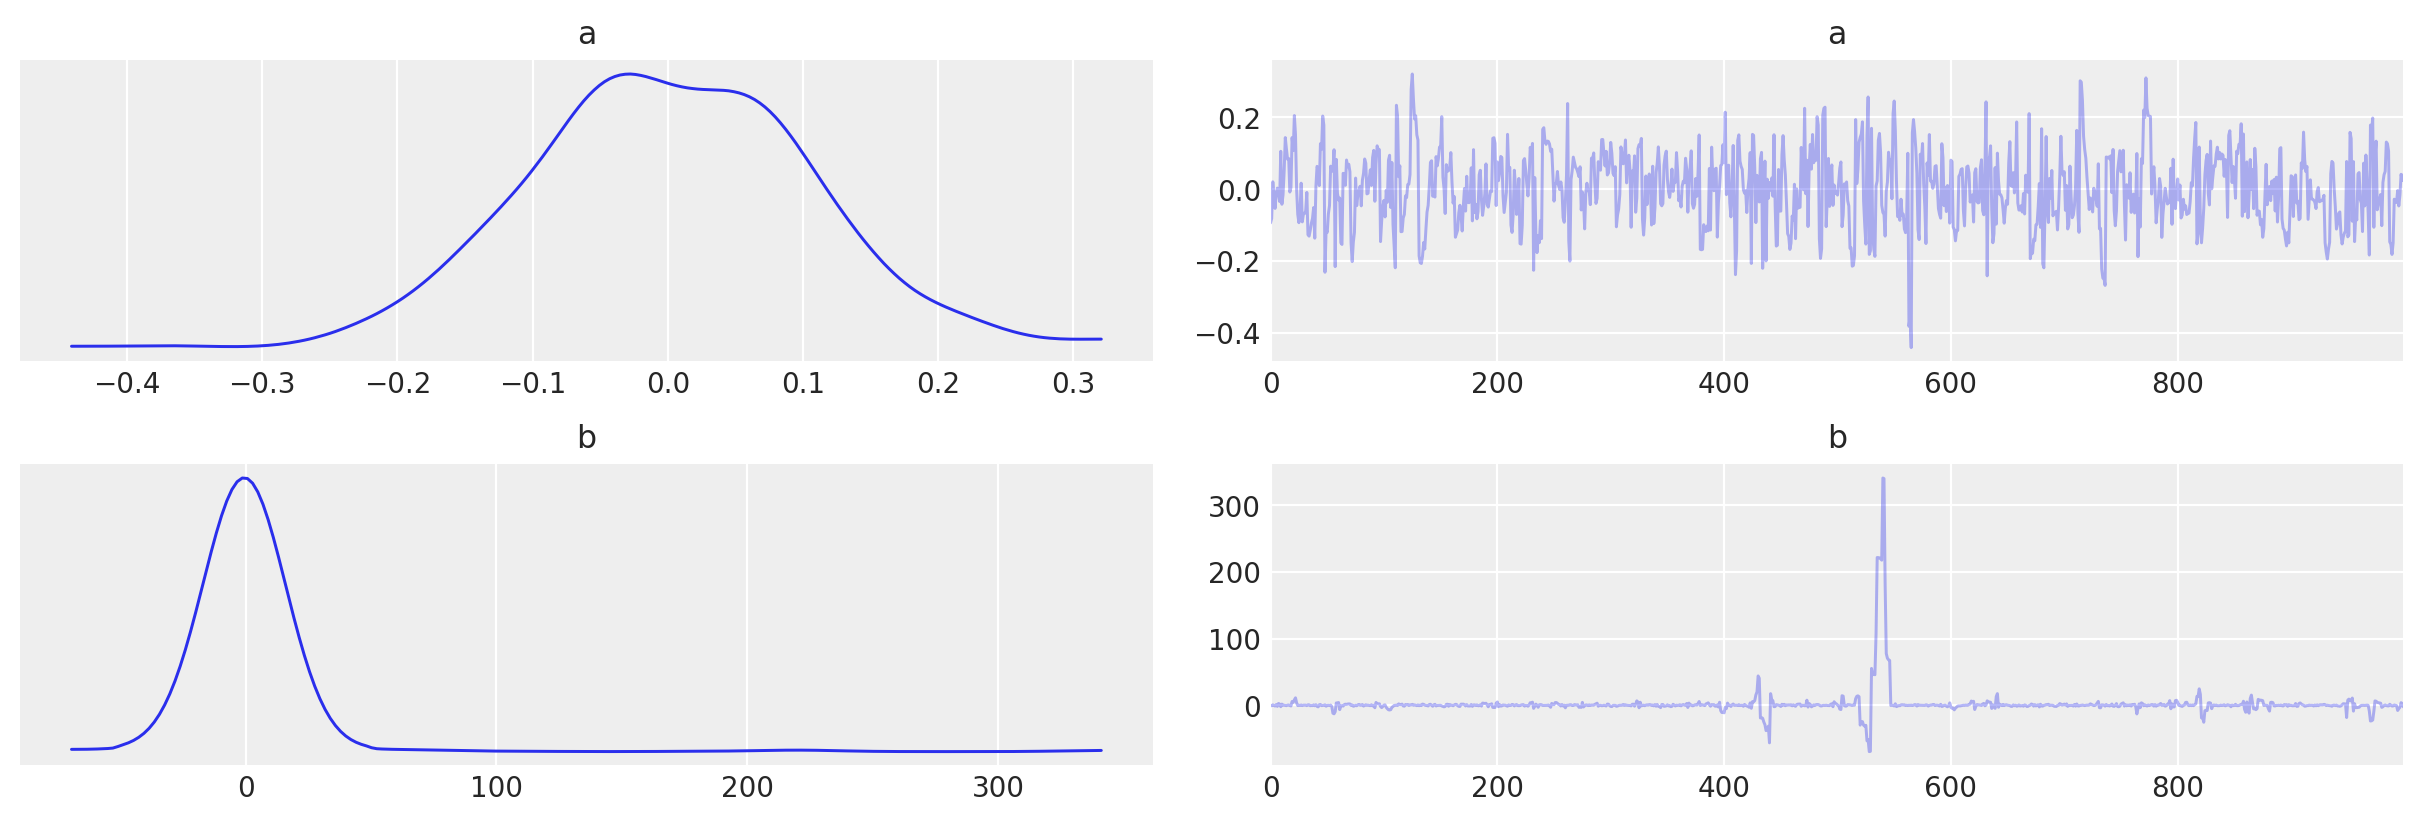

In [30]:
az.plot_trace(H1_post_sample);

Indeed, the trace plot goes go bonkers for b, as we periodically get extreme values. It breaks the stationarity criterion of a "healthy" chain. This all boils down to the Cauchy distribution being heavy tailed, so extreme outliers are relatively common for this distribution. The fact that the Cauchy distribution has no 1st moment implies that the Cauchy distribution doesn't converge to a mean as the sample size increases, defying the central limit theorem. Looking at parameter a, we see that the chain remains firmly located within a tiny narrow range of the sample space, as it should for the well behaved  normal distribution.

### 9H2.
Recall the divorce rate example from Chapter 5. Repeat that analysis, using ulam this time,
fitting models m5.1, m5.2, and m5.3. Use compare to compare the models on the basis of WAIC
or PSIS. To use WAIC or PSIS with ulam, you need add the argument log_log=TRUE. Explain the
model comparison results.

#### Answer 

In [31]:
# yoink the data
data = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")  # load waffle data

In [32]:
# scale all of the data
scaled_M = (data.Marriage - np.mean(data.Marriage)) / np.std(data.Marriage)
scaled_A = (data.MedianAgeMarriage - np.mean(data.MedianAgeMarriage)) / np.std(
    data.MedianAgeMarriage
)
scaled_D = (data.Divorce - np.mean(data.Divorce)) / np.std(data.Divorce)

One can peform linear regressions. I reproduce fig 5.2 showing the Bayesian linear regressions between Marriage rate and divorce rate asa well as Median Marriage age and divorce rate

In [33]:
# running a Age_divorce linear regression
with pm.Model() as m5_1:
    alpha = pm.Normal("alpha", mu=0, sd=0.2)  # prior on alpha
    beta = pm.Normal("beta_A", mu=0, sd=0.5)  # prior on beta
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta * scaled_A
    Divorce = pm.Normal(
        "Divorce", mu=mu, sd=sigma, observed=scaled_D
    )  # likelihood of the data
    # 1000 random samples on 4 chains
    m5_1_sample = pm.sample(draws=250, chains=4)


with pm.Model() as m5_2:
    alpha = pm.Normal("alpha", mu=0, sd=0.2)  # prior on alpha
    beta = pm.Normal("beta_M", mu=0, sd=0.5)  # prior on beta
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta * scaled_M
    Divorce = pm.Normal(
        "Divorce", mu=mu, sd=sigma, observed=scaled_D
    )  # likelihood of the data
    # 1000 random samples on 4 chains
    m5_2_sample = pm.sample(draws=250, chains=4)


with pm.Model() as m5_3:
    alpha = pm.Normal("alpha", mu=0, sd=0.2)  # prior on alpha
    beta = pm.Normal("beta_M", mu=0, sd=0.5, shape=2)  # prior on beta terms
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta[0] * scaled_A + beta[1] * scaled_M
    Divorce = pm.Normal(
        "Divorce", mu=mu, sd=sigma, observed=scaled_D
    )  # likelihood of the data
    # 1000 random samples on 4 chains
    m5_3_sample = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.


In [34]:
az.compare(
    {"m5_1": m5_1_sample, "m5_2": m5_2_sample, "m5_3": m5_3_sample}, scale="deviance"
)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pym

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5_1,0,126.991,3.80802,0,0.600336,13.9469,0,False,deviance
m5_3,1,128.235,4.59251,1.24404,0.308075,9.62986,0.890527,False,deviance
m5_2,2,140.287,2.97537,13.2955,0.0915894,13.5586,9.3009,False,deviance


We can see that k>0.7 for one of the models. This is probably due to some outliers within the data.

It can be seen that model 5.1 and 5.3 perform similarly in making predictions out of sample. Model 5.2 does much worse than the other two with a much larger deviance. Models 5.1 and 5.3 both include the age of the participants, with m5.3 also including the Marriage rate. m5.2 performs much worse than the other two models and just uses Marriage rate. This overall picture indicates that Marriage isn't a particularly predictive variable.

### 9H3.

Sometimes changing a prior for one parameter has unanticipated effects on other parameters.
This is because when a parameter is highly correlated with another parameter in the posterior, the
prior influences both parameters. Here’s an example to work and think through.

Go back to the leg length example in Chapter 6 and use the code there to simulate height and
leg lengths for 100 imagined individuals. Below is the model you fit before, resulting in a highly
correlated posterior for the two beta parameters. This time, fit the model using ulam:

m5.8s <- ulam(

alist(

height ~ dnorm( mu , sigma ) ,

mu <- a + bl * leg_left + br * leg_right ,

a ~ dnorm( 10 , 100 ) ,

bl ~ dnorm( 2 , 10 ) ,

br ~ dnorm( 2 , 10 ) ,

sigma ~ dexp( 1 )

) , data=d, chains=4,

start=list(a=10,bl=0,br=0.1,sigma=1) )

Compare the posterior distribution produced by the code above to the posterior distribution produced when you change the prior for br so that it is strictly positive:


m5.8s2 <- ulam(

alist(

height ~ dnorm( mu , sigma ) ,

mu <- a + bl * leg_left + br * leg_right ,

a ~ dnorm( 10 , 100 ) ,

bl ~ dnorm( 2 , 10 ) ,

br ~ dnorm( 2 , 10 ) ,

sigma ~ dexp( 1 )

) , data=d, chains=4,

constraints=list(br="lower=0"),

start=list(a=10,bl=0,br=0.1,sigma=1) )

Note the constraints list. What this does is constrain the prior distribution of br so that it has
positive probability only above zero. In other words, that prior ensures that the posterior distribution
for br will have no probability mass below zero. Compare the two posterior distributions for m5.8s
and m5.8s2. What has changed in the posterior distribution of both beta parameters? Can you
explain the change induced by the change in prior?

#### Answer 
 First is the code to resimulate the leg data. I copied this code from (https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb) I don't want to reinvent the wheel here.

In [46]:
# Stolen code for producing the simulated leg length data

N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(
    0, 0.02, N
)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(
    0, 0.02, N
)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,10.479782,5.101802,5.105552
1,8.938353,4.206689,4.196065
2,8.009189,3.536299,3.526946
3,9.434300,4.188748,4.181374
4,8.922743,3.879550,3.860163


In [48]:
# run the basic model

# define the sampling start point
start = {"a": 10, "bl": 0, "br": 0.1, "sigma": 1}

with pm.Model() as m5_8s:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)
    mu = a + bl * d.leg_left + br * d.leg_right
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    m5_8s_sample = pm.sample(draws=500, chains=2)


# run the constrained model

with pm.Model() as m5_8s2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    # bounding br parameter
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    br = BoundedNormal("br", 2, 10)
    mu = a + bl * d.leg_left + br * d.leg_right
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    b = pm.sample(draws=3000, chains=4, tune=2000, start=start)
    idata_m5_8s2 = az.from_pymc3(
        m5_8s2_sample
    )  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 60 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 59 seconds.
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1176 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3170271794672283, but should be close to 0.8. Try to increase the number of tuning steps.
There were 749 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48312163544282694, but should be close to 0.8. Try to increase the number of tuning steps.
There were 791 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4853281395169034, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samp

In [58]:
az.summary(m5_8s_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.859,0.327,0.239,1.469,0.015,0.011,484.0,484.0,486.0,422.0,1.01
bl,-1.246,2.192,-4.985,2.771,0.132,0.093,278.0,278.0,277.0,471.0,1.01
br,3.258,2.194,-0.440,7.365,0.132,0.093,278.0,278.0,278.0,462.0,1.00
sigma,0.637,0.041,0.565,0.711,0.002,0.001,473.0,473.0,458.0,411.0,1.00


In [59]:
az.summary(m5_8s2_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.921,0.351,0.326,1.498,0.096,0.069,13.0,13.0,15.0,92.0,1.19
bl,1.629,0.197,1.274,1.989,0.051,0.037,15.0,15.0,14.0,40.0,1.22
br,0.370,0.189,0.025,0.641,0.049,0.038,15.0,13.0,15.0,130.0,1.19
sigma,0.626,0.042,0.550,0.707,0.007,0.005,34.0,34.0,30.0,97.0,1.10


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


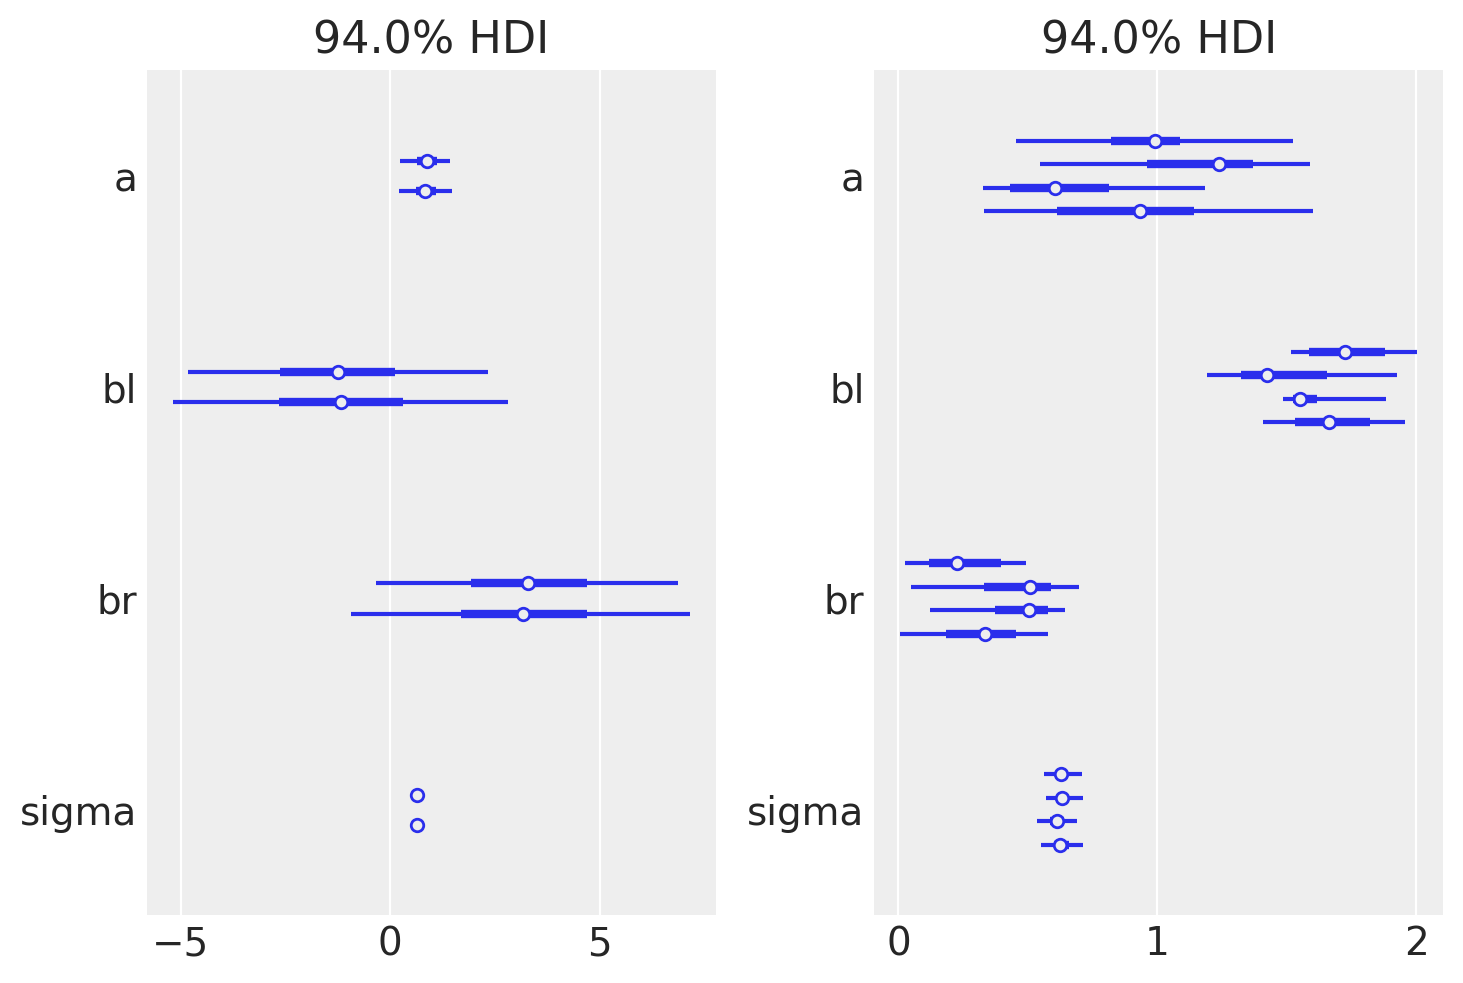

In [60]:
fig, axs = plt.subplots(1, 2)
az.plot_forest(m5_8s_sample, ax=axs[0])
az.plot_forest(m5_8s2_sample, ax=axs[1]);

Bounding the prior in this way constrains br to be positive.

In [41]:
with m5_8s:
    test_sample = pm.sample(draws=500, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 58 seconds.
The acceptance probability does not match the target. It is 0.879580514503861, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [42]:
az.summary(test_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.441,0.321,0.822,2.025,0.013,0.009,640.0,640.0,627.0,552.0,1.01
bl,3.551,2.068,-0.245,7.435,0.104,0.076,394.0,371.0,392.0,356.0,1.00
br,-1.643,2.054,-5.590,2.017,0.103,0.081,398.0,326.0,392.0,369.0,1.00
sigma,0.589,0.045,0.503,0.664,0.002,0.002,440.0,415.0,508.0,352.0,1.00


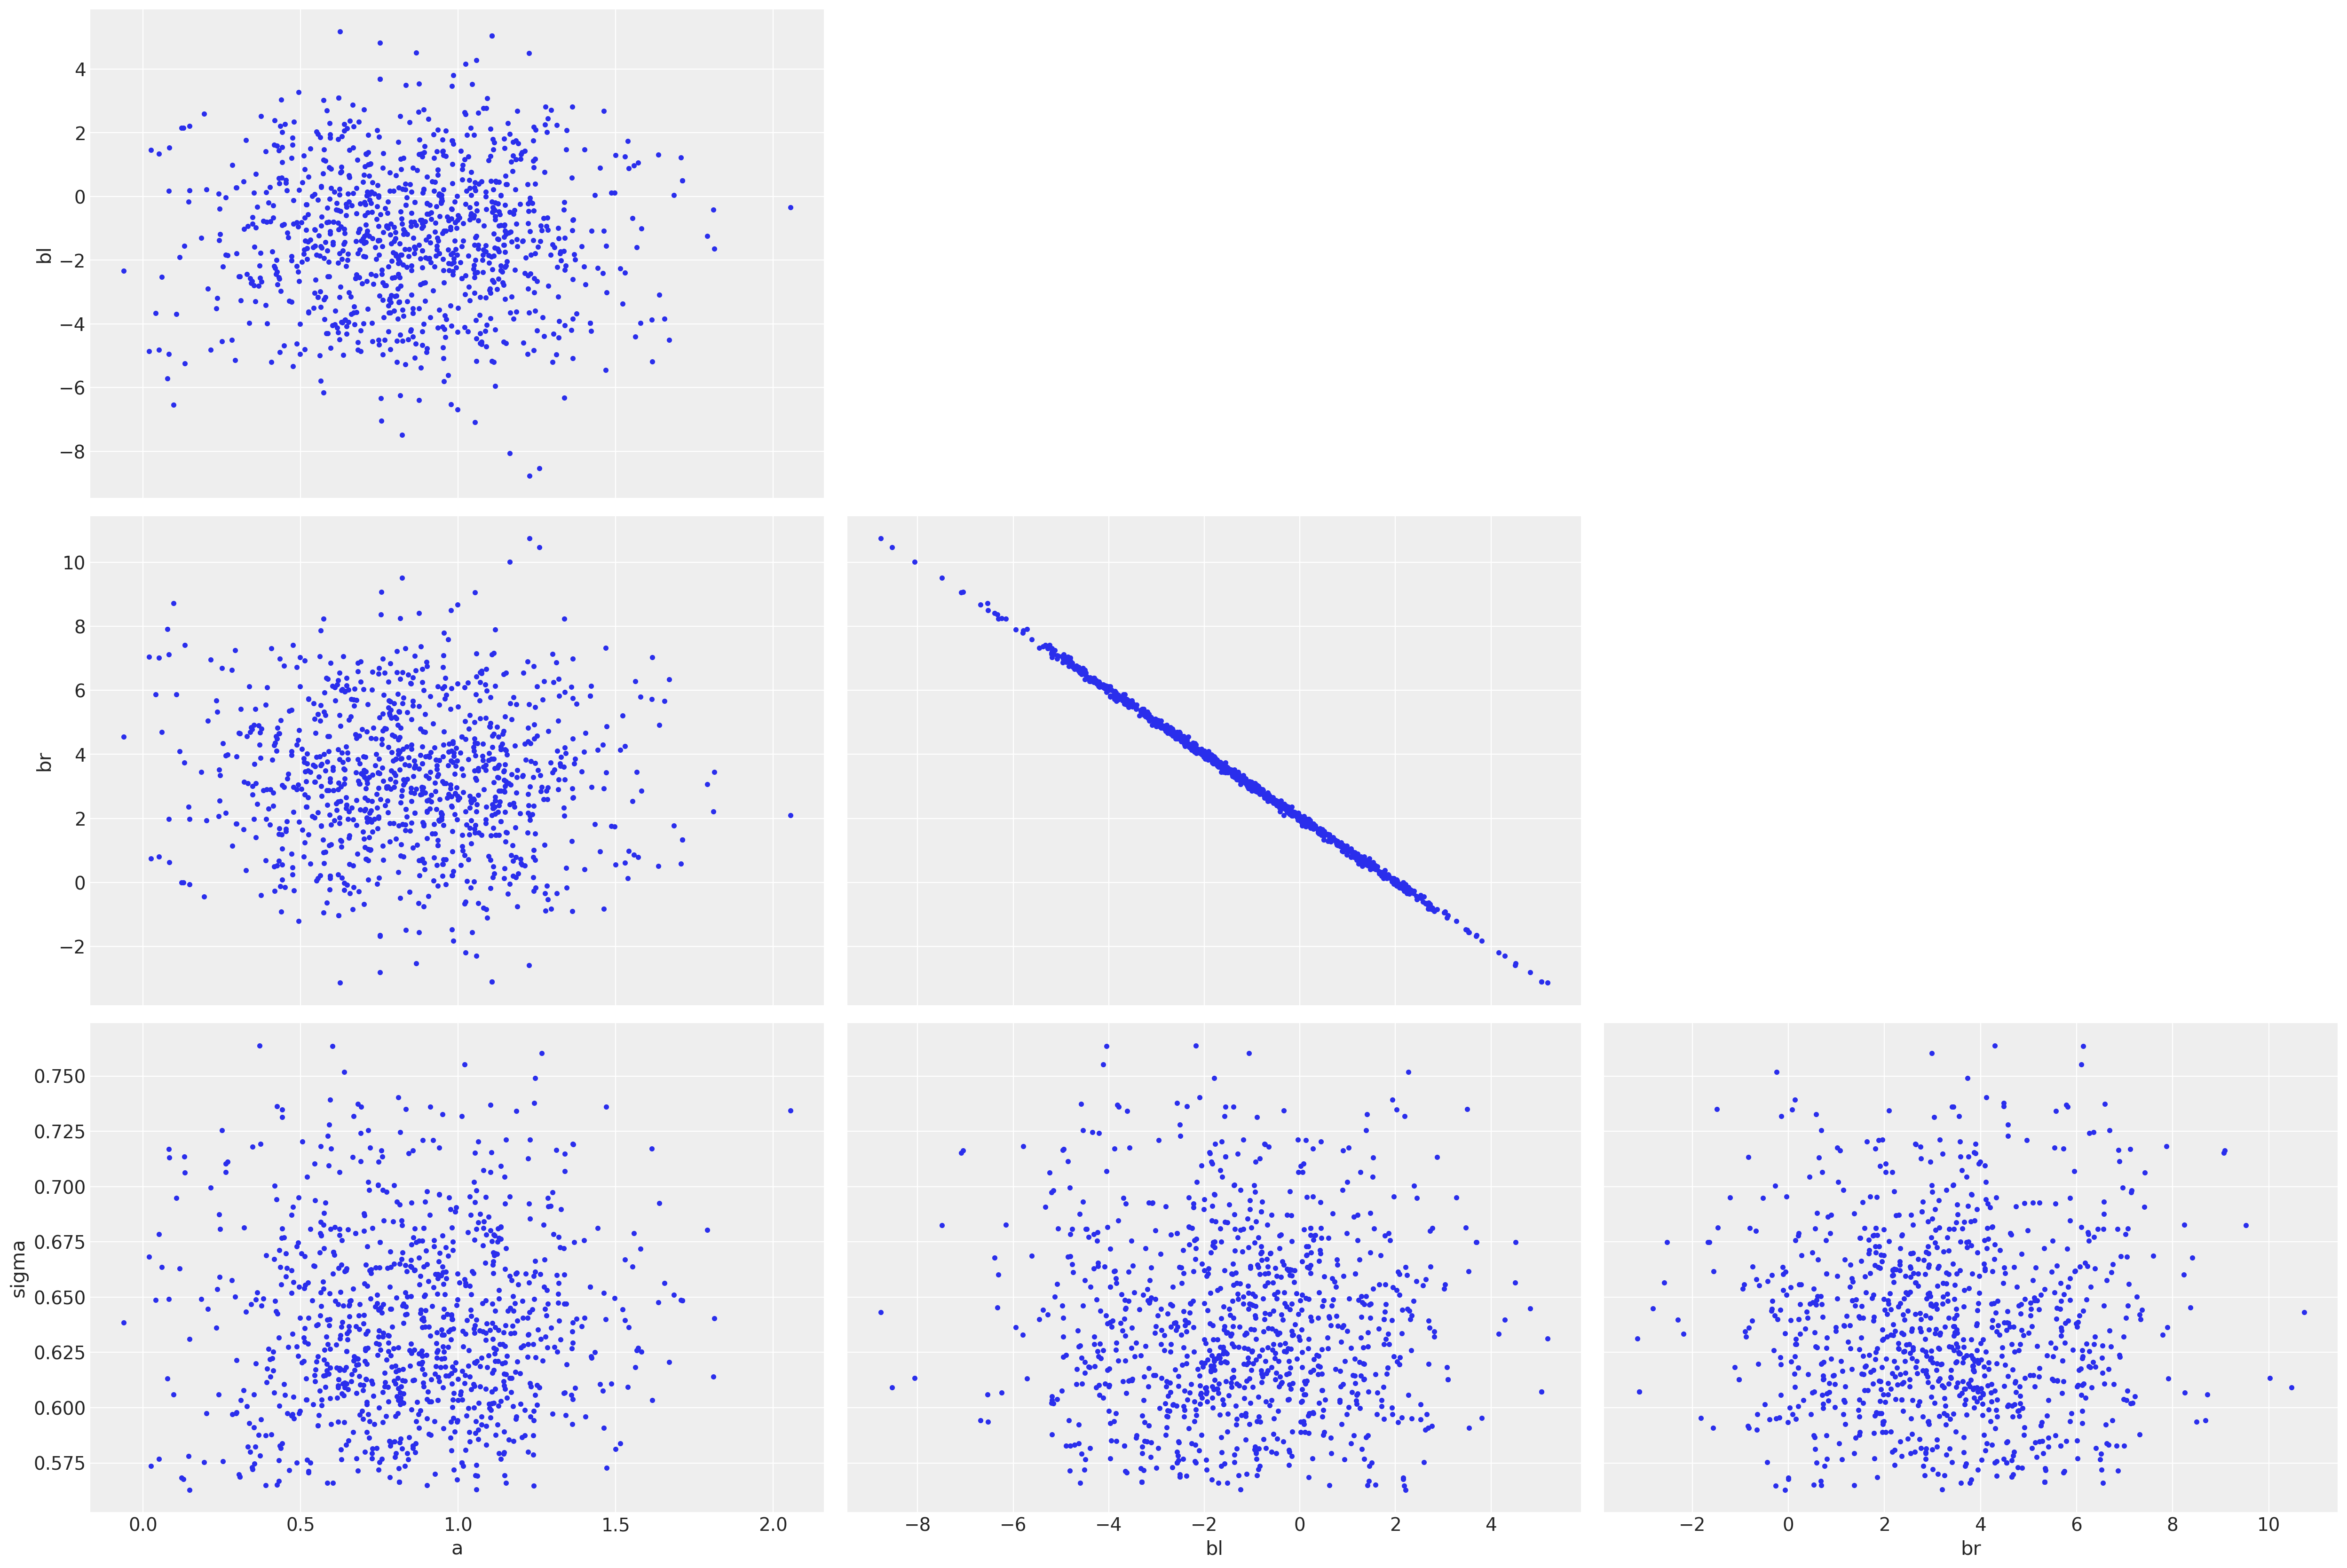

In [52]:
az.plot_pair(m5_8s_sample);

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


(array([[<AxesSubplot:ylabel='bl'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='br'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='a', ylabel='sigma'>,
         <AxesSubplot:xlabel='bl'>, <AxesSubplot:xlabel='br'>]],
       dtype=object),)

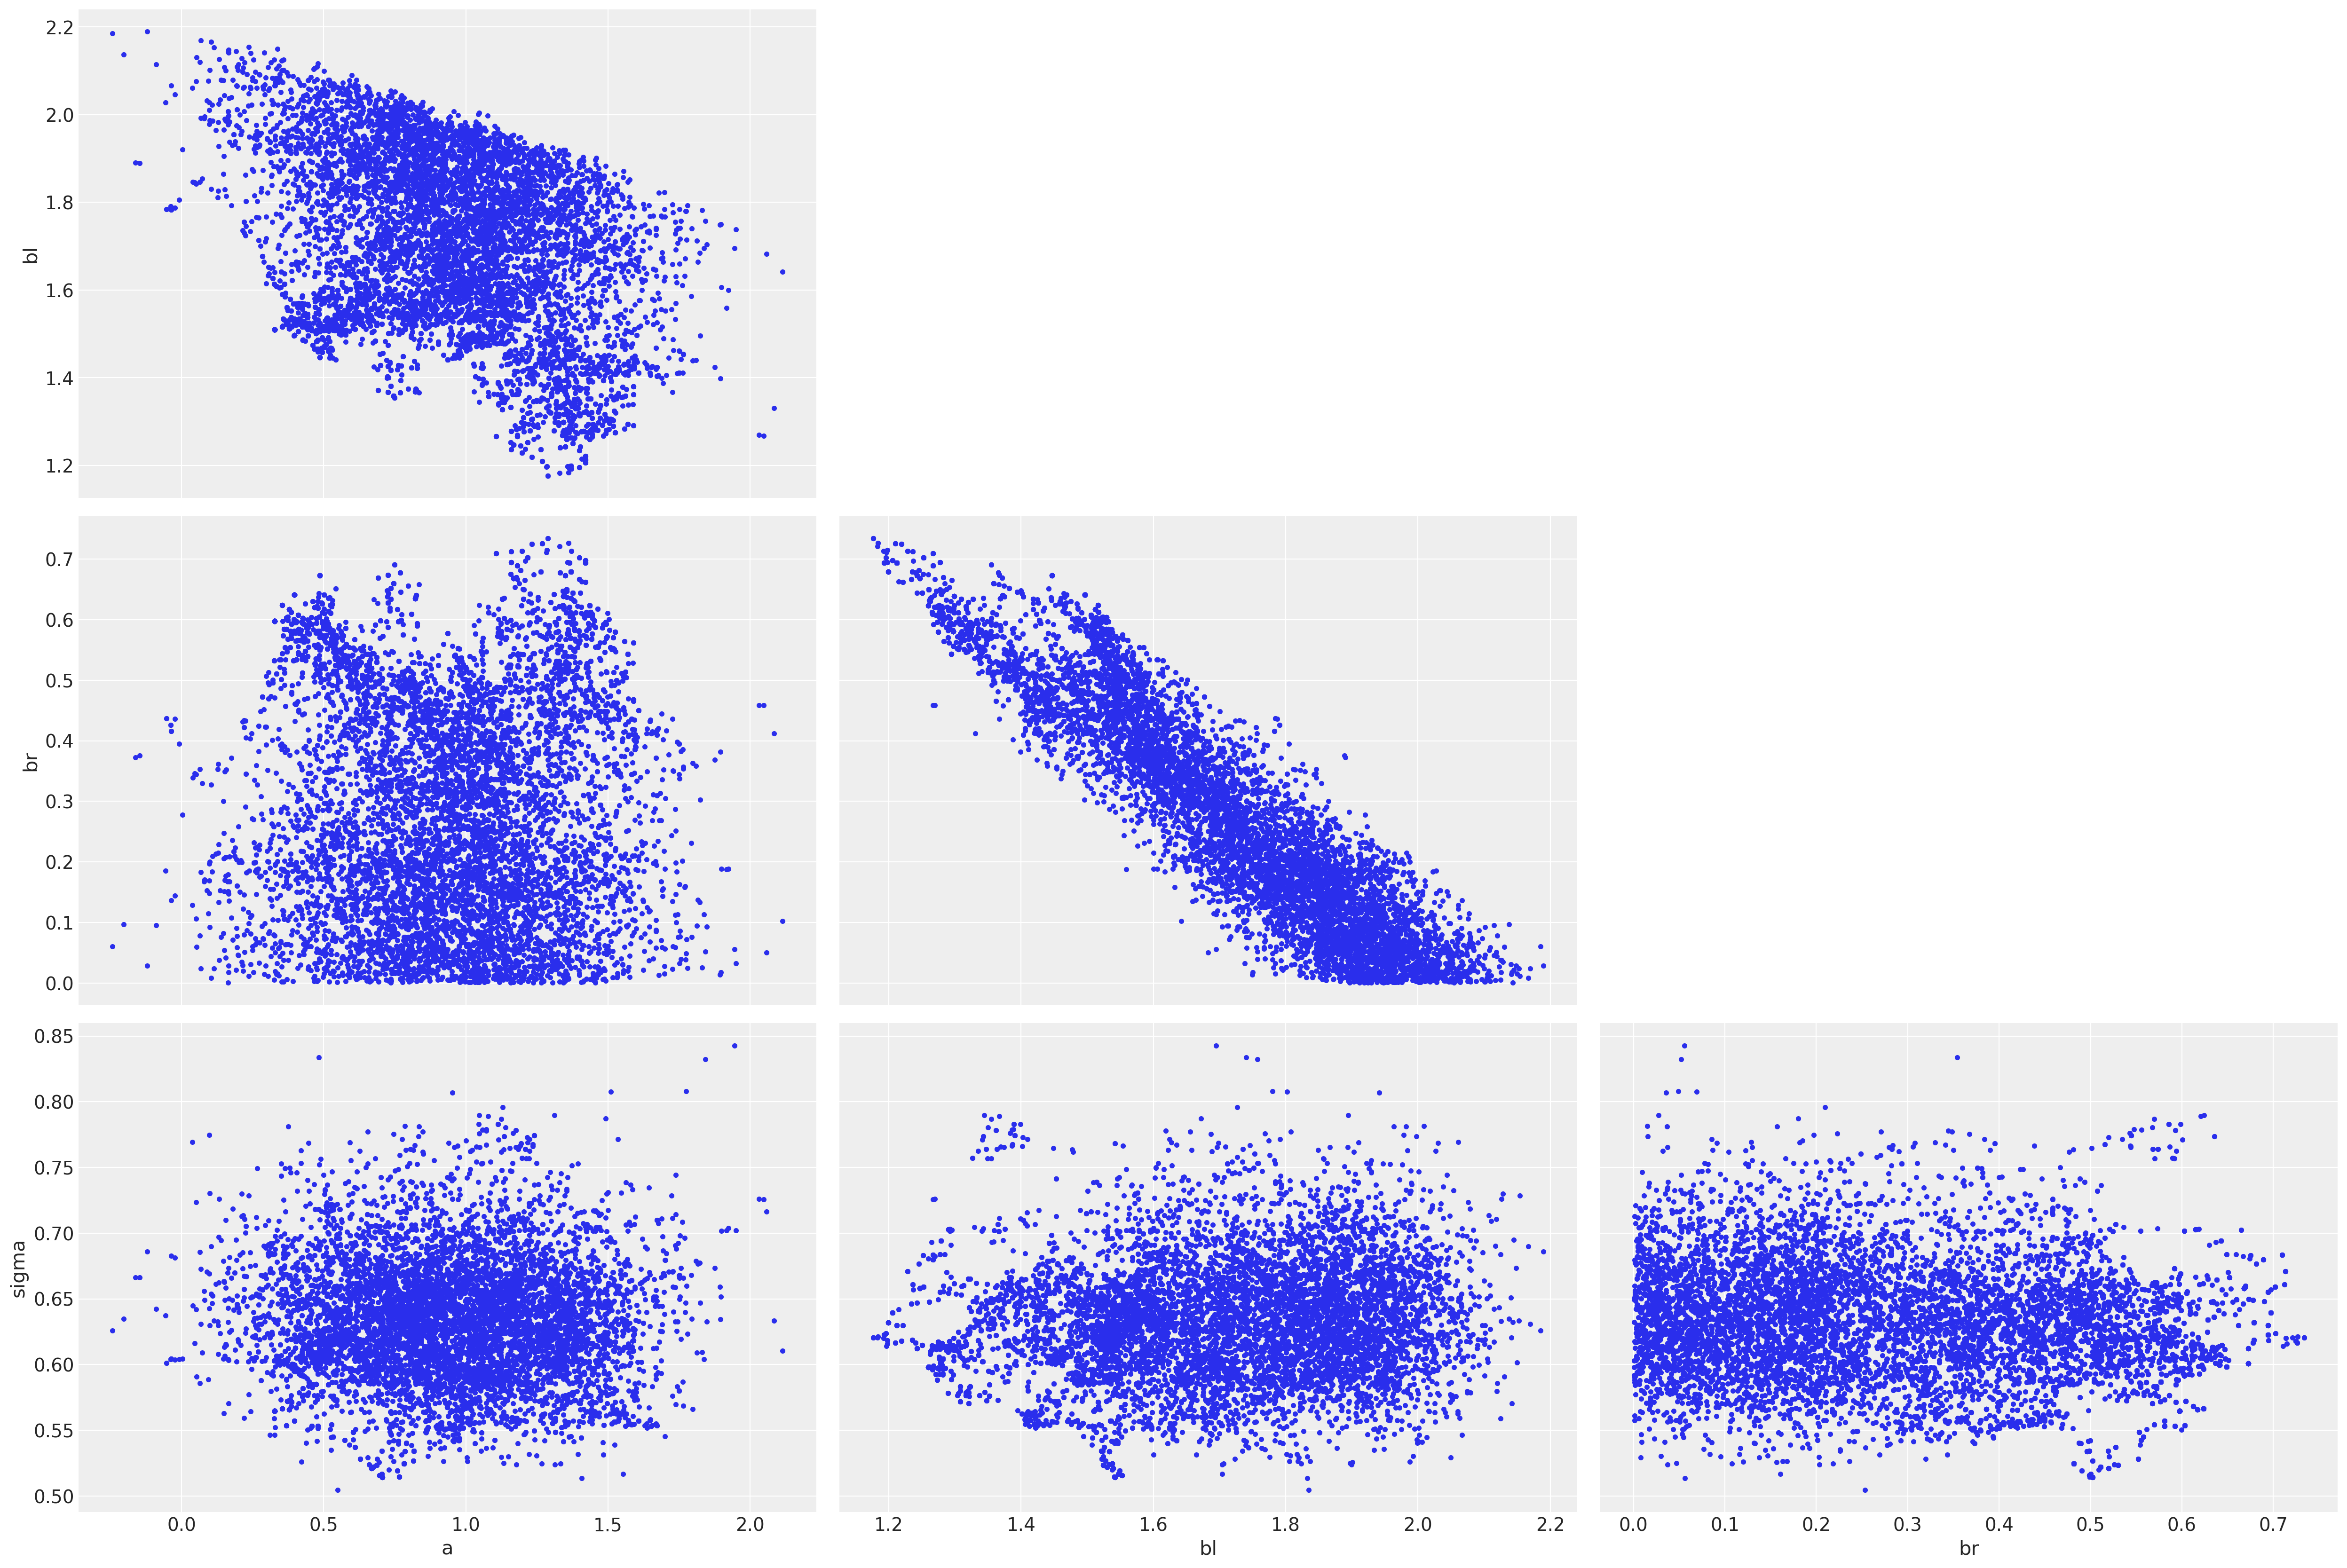

In [54]:
az.plot_pair(m5_8s2_sample),

These look truly hideous for the second model. I think the sample didn't work very well here because of the many many divergences that took place during the sampling process. The number of effective samples is also

### 9H4.

For the two models fit in the previous problem, use WAIC or PSIS to compare the effective
numbers of parameters for each model. You will need to use log_lik=TRUE to instruct ulam to
compute the terms that both WAIC and PSIS need. Which model has more effective parameters?
Why?


In [ ]:
compare_df = az.compare({"m5_8s": m5_8s_sample, "m5_8s2": m5_8s2_sample}, scale="deviance")
az.plot_compare(compare_df)

In [34]:
%watermark -n -u -v -iv -w

Last updated: Fri Dec 11 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy     : 1.19.1
pandas    : 1.1.3
pymc3     : 3.9.3
arviz     : 0.9.0
matplotlib: 3.3.2

Watermark: 2.1.0

